In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from numpy.linalg import norm

In [2]:
###Modify parameter space based on the visualization of solubility and spray ability of initial sampling conditions
MACl_min, MACl_max, MACl_step = [0, 30, 5] ## Unit: %, 11 steps
MACl_var = np.arange(MACl_min, MACl_max+MACl_step*0.1, MACl_step)
MACl_num = len(MACl_var)

DMF_min, DMF_max, DMF_step = [0, 90, 5] ## Unit: %, 21 steps
DMF_var = np.arange(DMF_min, DMF_max+DMF_step*0.1, DMF_step)
DMF_num = len(DMF_var)

V_min, V_max, V_step = [15, 30, 0.5] ## Unit: KV, 21 steps
V_var = np.arange(V_min, V_max+V_step*0.1, V_step)
V_num = len(V_var)

Q_min, Q_max, Q_step = [0.7, 1.7, 0.05] ## Unit: μL/min, # 21 steps
Q_var = np.arange(Q_min, Q_max+Q_step*0.1, Q_step)
Q_num = len(Q_var)

T_min, T_max, T_step = [100, 150, 5] ## Unit: ℃, # 11 steps
T_var = np.arange(T_min, T_max+T_step*0.1, T_step)
T_num = len(T_var)

t_min, t_max, t_step = [10, 30, 5] ## Unit: min, # 5 steps
t_var = np.arange(t_min, t_max+t_step*0.1, t_step)
t_num = len(t_var)


var_array = [MACl_var, DMF_var, 
             V_var, Q_var,
            T_var,t_var]

x_labels = ['MACl [%]', 
            'DMF [%]', 
            'V [KV]', 
            'Q [uL/min]',
            'T [\N{DEGREE SIGN}C]',
            't [min]']    

In [3]:
def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)

def get_closest_value(given_value, array_list):
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    closest_value = min(array_list, key=absolute_difference_function)
    return closest_value
    
def get_closest_array(suggested_x, var_list):
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
### Add/minus a half step to make sure the edge conditions have the same chance in nearest neighbors
parameter_space = ParameterSpace([ContinuousParameter('x1', 0-1/(MACl_num-1)/2, 1+1/(MACl_num-1)/2),
                                  ContinuousParameter('x2', 0-1/(DMF_num-1)/2,  1+1/(DMF_num-1)/2),
                                  ContinuousParameter('x3', 0-1/(V_num-1)/2,    1+1/(V_num-1)/2),
                                  ContinuousParameter('x4', 0-1/(Q_num-1)/2,    1+1/(Q_num-1)/2),
                                  ContinuousParameter('x5', 0-1/(T_num-1)/2,    1+1/(T_num-1)/2),
                                  ContinuousParameter('x6', 0-1/(t_num-1)/2,    1+1/(t_num-1)/2)])

In [5]:
np.random.seed(10) # to make sure the random results is reproducible 

design = LatinDesign(parameter_space)
x_init = design.get_samples(15)#sampling >15 to account for at least 10 promising candidate conditions
x_init_original = get_closest_array(x_denormalizer(x_init, var_array),var_array)

df = pd.DataFrame(x_init_original, columns = x_labels)
df_cols = x_labels
df

,MACl [%],DMF [%],V [KV],Q [uL/min],T [°C],t [min]
0,25.0,40.0,15.5,1.55,145.0,30.0
1,30.0,65.0,17.5,1.20,145.0,30.0
2,10.0,25.0,23.5,0.80,125.0,25.0
3,15.0,5.0,29.5,1.05,140.0,15.0
4,15.0,75.0,18.5,0.85,105.0,10.0
5,20.0,15.0,22.5,1.50,100.0,15.0
6,30.0,45.0,21.5,1.60,130.0,30.0
7,5.0,20.0,19.5,1.25,130.0,25.0
8,0.0,90.0,25.5,1.70,120.0,10.0
9,10.0,85.0,20.5,1.40,115.0,20.0


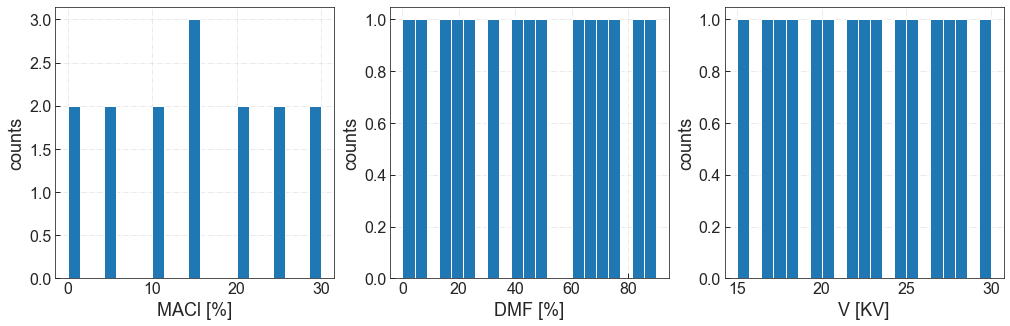

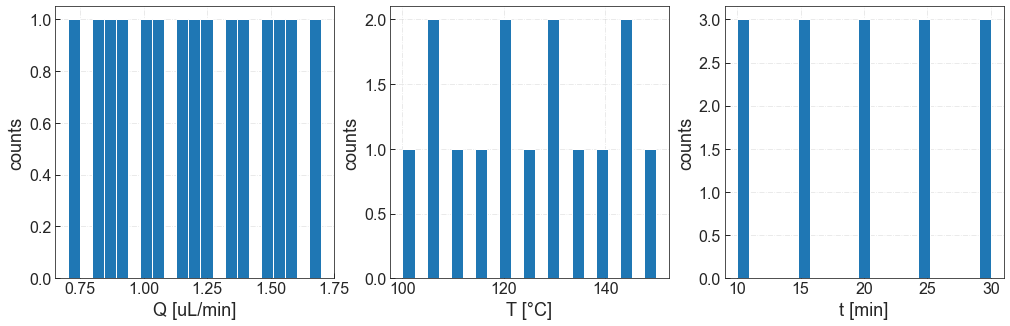

In [7]:
sns.set_style("ticks",{'xtick.direction': 'in',
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})

n_col = 3
for n in np.arange(0, 6, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(17, 5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            max_ = max(var_array[n])
            min_ = min(var_array[n])
            axes[i].hist(df.iloc[:,n], bins = 21, range = (min_, max_))
            axes[i].set_xlabel(df_cols[n], fontsize = 18)

        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    axes[1].set_ylabel('counts', fontsize = 18)
    axes[2].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

In [8]:
IO="C:\\Users\\PY\\Desktop\\Initial Sampling-Final.xlsx"

In [9]:
df.to_excel(IO,"Initial Sampling-Final.xlsx") 

### Paralell Plot 

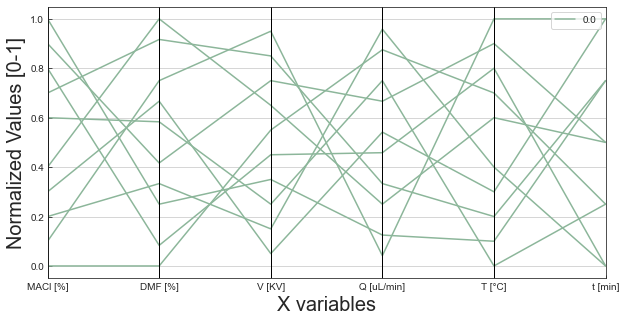

In [9]:
df_parallel = pd.DataFrame(x_normalizer(x_init_original, var_array), columns = x_labels)

df_parallel['Efficiency [%]'] = np.zeros(len(df))

fig,axes = plt.subplots(1,1, figsize=(10,5))
pd.plotting.parallel_coordinates(df_parallel,'Efficiency [%]',ax=axes)
axes.set_ylim(-0.05,1.05)
axes.set_ylabel('Normalized Values [0-1]',fontsize=20)
axes.set_xlabel('X variables',fontsize=20)
plt.show()

### tSNE Visualisation

In [10]:
np.random.seed(10) # to make sure the random results is reproducible 

design = RandomDesign(parameter_space)
x_sample = design.get_samples(5000)
x_sample_original = get_closest_array(x_denormalizer(x_sample, var_array),var_array)
X = np.append(x_sample,x_normalizer(x_init_original,var_array), axis = 0)

from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components=n_components, random_state=0)
Y = tsne.fit_transform(X)  # 

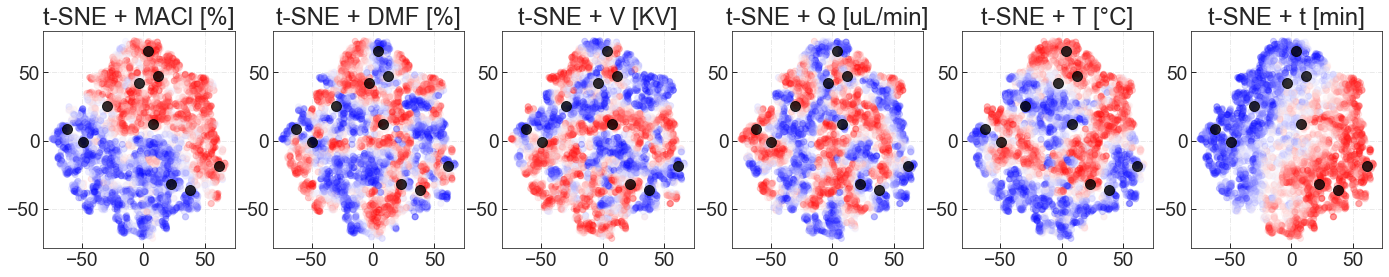

In [11]:
fig, axes = plt.subplots(1,6, figsize=(6*4, 4))

ax = axes[0]
ax.scatter(Y[:, 0], Y[:, 1],c = X[:,0], cmap=plt.cm.bwr, alpha = 0.2)
ax.scatter(Y[-10:, 0], Y[-10:, 1],color = 'black', alpha = 0.8, s = 100)
ax.set_title("t-SNE + " + str(x_labels[0]), fontsize = 24)

ax = axes[1]
ax.scatter(Y[:, 0], Y[:, 1],c = X[:,1], cmap=plt.cm.bwr, alpha = 0.2)
ax.scatter(Y[-10:, 0], Y[-10:, 1],color = 'black', alpha = 0.8, s = 100)
ax.set_title("t-SNE + " + str(x_labels[1]), fontsize = 24)

ax = axes[2]
ax.scatter(Y[:, 0], Y[:, 1],c = X[:,2], cmap=plt.cm.bwr, alpha = 0.2)
ax.scatter(Y[-10:, 0], Y[-10:, 1],color = 'black', alpha = 0.8, s = 100)
ax.set_title("t-SNE + " + str(x_labels[2]), fontsize = 24)


ax = axes[3]
ax.scatter(Y[:, 0], Y[:, 1],c = X[:,3], cmap=plt.cm.bwr, alpha = 0.2)
ax.scatter(Y[-10:, 0], Y[-10:, 1],color = 'black', alpha = 0.8, s = 100)
ax.set_title("t-SNE + " + str(x_labels[3]), fontsize = 24)

ax = axes[4]
ax.scatter(Y[:, 0], Y[:, 1],c = X[:,4], cmap=plt.cm.bwr, alpha = 0.2)
ax.scatter(Y[-10:, 0], Y[-10:, 1],color = 'black', alpha = 0.8, s = 100)
ax.set_title("t-SNE + " + str(x_labels[4]), fontsize = 24)

ax = axes[5]
ax.scatter(Y[:, 0], Y[:, 1],c = X[:,5], cmap=plt.cm.bwr, alpha = 0.2)
ax.scatter(Y[-10:, 0], Y[-10:, 1],color = 'black', alpha = 0.8, s = 100)
ax.set_title("t-SNE + " + str(x_labels[5]), fontsize = 24)

for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = 24*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')


plt.show()